# Introduction to Machine Learning

Written by Morgan Schwartz and David Van Valen.

---

In this exercise, we are going to follow the basic workflow that is the foundation of any machine or deep learning project
1. Data wrangling
2. Model configuration and training
3. Model evaluation

Along the way, we will implement a linear classifier, test a random forest classifier and explore the role of feature engineering in traditional machine learning.

We are going to look at a collection of images of Jurkat cells published in the Broad Bioimage Collection ([BBBC048](https://bbbc.broadinstitute.org/BBBC048)). The cells were fixed and stained with PI (propidium iodide) to quantify DNA content and a MPM2 (mitotic protein monoclonal #2) antibody to identify mitotic cells. The goal is to predict the stage of the cell cycle from images like those shown below.

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-017-00623-3/MediaObjects/41467_2017_623_Fig2_HTML.jpg?as=webp)

[Eulenberg et al. (2017) Reconstructing cell cycle and disease progression using deep learning. Nature communications](https://www.nature.com/articles/s41467-017-00623-3)

<div class="alert alert-danger">
Set your python kernel to <code>01_intro_ml</code>

![](images/kernel-change.png)
</div>

# Part A: The Linear Classifier

While deep learning might seem intimidating, don't worry. Its conceptual underpinnings are rooted in linear algebra and calculus - if you can perform matrix multiplication and take derivatives you can understand what is happening in a deep learning workflow. In this section, we will implement a simple linear classifier by hand and train it to predict cell cycle stages.

In [79]:
from collections import Counter
import os

import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import tqdm.auto

## The supervised machine learning workflow
Recall from class the conceptual workflow for a supervised machine learning project.
- First, we create a <em>training dataset</em>, a paired collection of raw data and labels where the labels contain information about the "insight" we wish to extract from the raw data.
- Once we have training data, we can then use it to train a <em>model</em>. The model is a mathematical black box - it takes in data and transforms it into an output. The model has some parameters that we can adjust to change how it performs this mapping.
- Adjusting these parameters to produce outputs that we want is called training the model. To do this we need two things. First, we need a notion of what we want the output to look like. This notion is captured by a <em>loss function</em>, which compares model outputs and labels and produces a score telling us if the model did a "good" job or not on our given task. By convention, low values of the loss function's output (e.g. the loss) correspond to good performance and high values to bad performance. We also need an <em>optimization algorithm</em>, which is a set of rules for how to adjust the model parameters to reduce the loss
- Using the training data, loss function, and optimization algorithm, we can then train the model
- Once the model is trained, we need to evaluate its performance to see how well it performs and what kinds of mistakes it makes. We can also perform this kind of monitoring during training (this is actually a standard practice).

Because this workflow defines the lifecycle of most machine learning projects, this notebook is structured to go over each of these steps while constructing a linear classifier.

## Create training data

During the initial setup of this exercise, we downloaded the data and unzipped the relevant files using the script `setup.sh`.

In [4]:
data_dir = "data/CellCycle"
sorted(os.listdir(data_dir))

['66.lst~',
 'Anaphase',
 'G1',
 'G2',
 'Metaphase',
 'Prophase',
 'S',
 'Telophase',
 'img.lst',
 'img.lst~']

The command above should generate the following output. If you see something different, please check that the `setup.sh` script ran correctly.
```
['66.lst~',
 'Anaphase',
 'G1',
 'G2',
 'Metaphase',
 'Prophase',
 'S',
 'Telophase',
 'img.lst',
 'img.lst~']
```

The metadata for each file is stored in `img.lst` so we will first load this information to inform how we load the rest of the dataset.

In [5]:
# Read the csv file using pandas
df = pd.read_csv(os.path.join(data_dir, "img.lst"), sep="\t", header=None)

# Rename columns to make the data easier to work with
df = df.rename(columns={1: "class", 2: "filepath"})

# Extract the channel information from the filepath column and create a new column with it
df["channel"] = (
    df["filepath"]
    .str.split("/", expand=True)[2]
    .str.split("_", expand=True)[1]
    .str.slice(2, 3)
)

# Extract the file ID from the filepath and save in its own column
df["id"] = df["filepath"].str.split("/", expand=True)[2].str.split("_", expand=True)[0]

# Look at the first few rows in the dataframe
df.head()

,0,class,filepath,channel,id
0,19,0,./Anaphase/12432_Ch3.ome.jpg,3,12432
1,8,0,./Anaphase/12432_Ch4.ome.jpg,4,12432
2,35,0,./Anaphase/12432_Ch6.ome.jpg,6,12432
3,36,0,./Anaphase/22004_Ch3.ome.jpg,3,22004
4,1,0,./Anaphase/22004_Ch4.ome.jpg,4,22004


In [6]:
# Check the total number of unique classes in the dataset
df["class"].unique()

array([0, 4, 5, 1, 2, 6, 3])

In [7]:
class_lut = ["Ana", "Meta", "Pro", "Telo", "G1", "G2", "S"]

For each `id` there are three images. One for each of the channels: phase, PI and MPM2. Let's take a look at a single image

/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_3727/4148965358.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im3 = iio.imread(os.path.join(data_dir, filepath))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_3727/4148965358.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im4 = iio.imread(os.path.join(data_dir, filepath))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_3727/4148965358.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make 

Text(0.5, 1.0, 'MPM2')

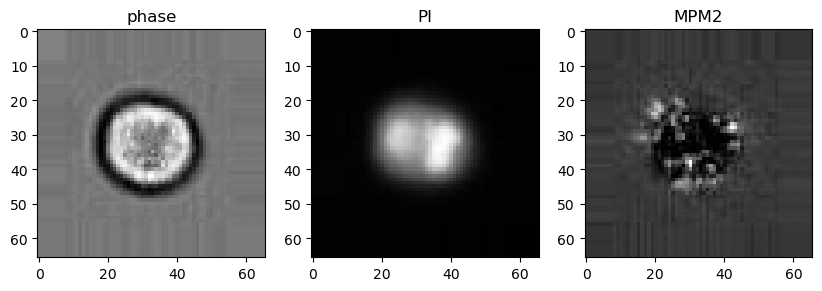

In [10]:
im_id = "12432"

# Load channel 3
filepath = df[(df["id"] == im_id) & (df["channel"] == "3")]["filepath"].values[0]
im3 = iio.imread(os.path.join(data_dir, filepath))

# Load channel 4
filepath = df[(df["id"] == im_id) & (df["channel"] == "4")]["filepath"].values[0]
im4 = iio.imread(os.path.join(data_dir, filepath))

# Load channel 6
filepath = df[(df["id"] == im_id) & (df["channel"] == "6")]["filepath"].values[0]
im6 = iio.imread(os.path.join(data_dir, filepath))

# Create a matplotlib subplot with one row and 3 columns
# Plot each of the three images
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(im3, cmap="Greys_r")
ax[0].set_title("phase")
ax[1].imshow(im4, cmap="Greys_r")
ax[1].set_title("PI")
ax[2].imshow(im6, cmap="Greys_r")
ax[2].set_title("MPM2")

Now we can load all of the images into a dataset. We will want to load each of the three channels for each image and create an array with the shape (w, h, ch). Then we will combine all images in the dataset into a single array.

In [11]:
# Create empty lists to hold images and classes as we load them
ims = []
ys = []

# Iterate over each unique id in the dataset
for i, g in df.groupby("id"):
    im = []

    # Each row in the group corresponds to a different channel for a single image/id
    for _, r in g.iterrows():
        # Set the complete filepath for this image
        path = os.path.join(data_dir, r["filepath"])

        # Load in the data using imageio and append to a list
        im.append(iio.imread(path))

    # Stack a list of three images into a single
    im = np.stack(im, axis=-1)
    ims.append(im)
    ys.append(r["class"])

X_data = np.stack(ims)
y_data = np.stack(ys)
print("X shape:", X_data.shape)
print("y shape:", y_data.shape)

/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_3727/1367676586.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im.append(iio.imread(path))


X shape: (32266, 66, 66, 3)
y shape: (32266,)


In the previous cell, you probably observed that there are 4 dimensions rather than the 3 you might have been expecting. This is because while each image is (66, 66, 3), the full dataset has many images. The different images are stacked along the first dimension. The full size of the training images is (# images, 66, 66, 3).

Let's take a look at a sample image from each class and plot each of the three channels separately.

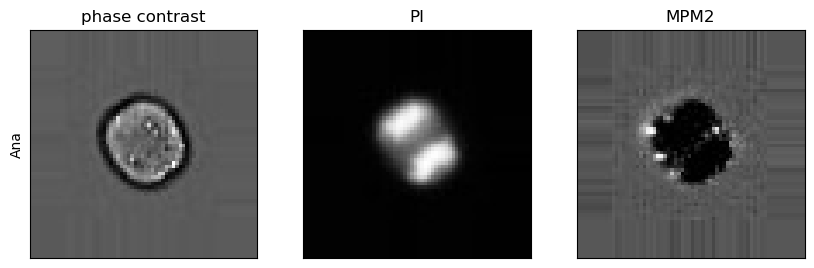

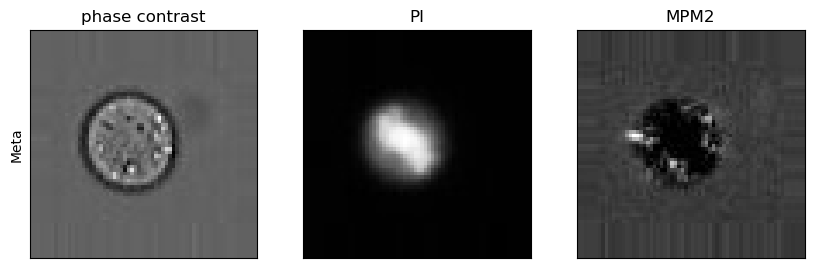

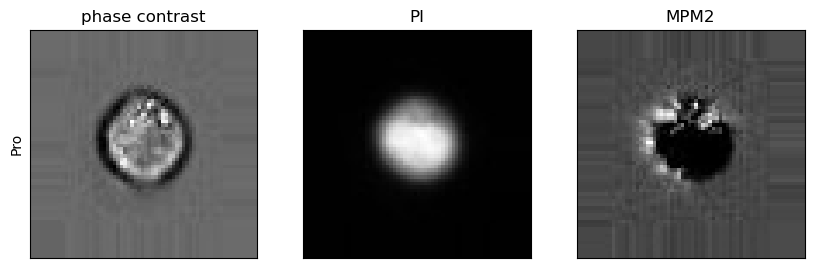

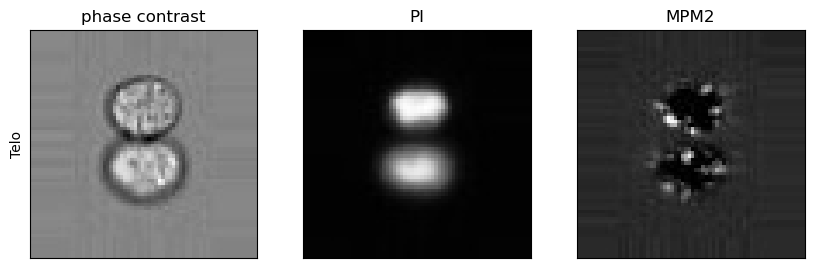

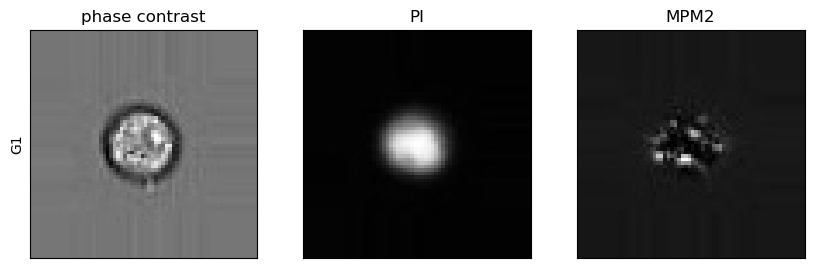

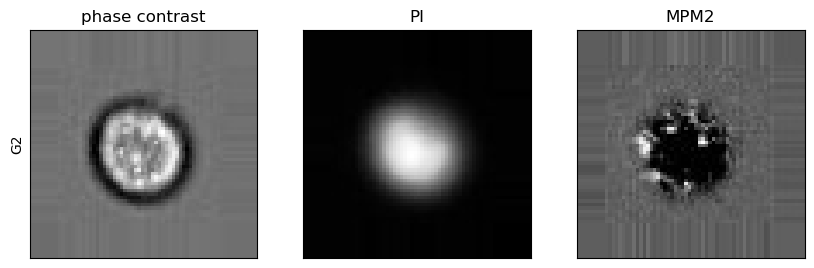

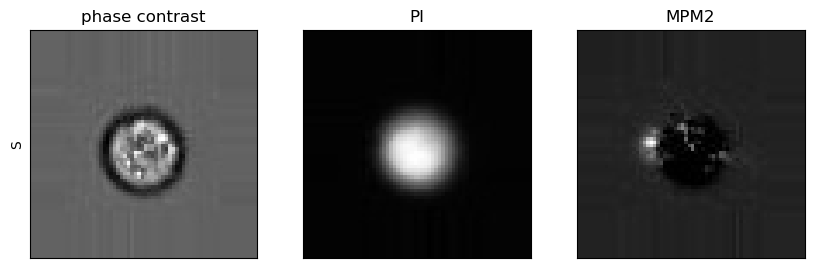

In [12]:
# Iterate over each class in the dataset
for c in np.unique(y_data):
    # Select a random index for the class of interest
    i = np.random.choice(np.where(y_data == c)[0])

    # Create a matplotlib subplot with one row and 3 columsn
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].set_ylabel(class_lut[c])

    # Plot each of the three channels
    for j, ch in enumerate(["phase contrast", "PI", "MPM2"]):
        ax[j].imshow(X_data[i, ..., j], cmap="Greys_r")
        ax[j].set_title(ch)
        ax[j].xaxis.set_tick_params(labelbottom=False)
        ax[j].yaxis.set_tick_params(labelleft=False)
        ax[j].set_xticks([])
        ax[j].set_yticks([])

For this exercise, we will want to flatten the training data into a vector and select a single channel to work with. We work with the phase channel first.

In [13]:
# Record the original width so that we can use this for reshaping later
image_width = X_data.shape[1]
image_width

66

In [14]:
# Flatten the images 1d vectors
X_flat = np.reshape(X_data[..., 0], (-1, image_width * image_width))
print(X_flat.shape)

(32266, 4356)


### Checking Class Balance

<div class="alert alert-block alert-info">

#### Task 1.1

Let's check the balance of classes in this dataset (stored in `y_data`). There are at least three ways you could do this. Pick one to try.

- Count the number of items in each class using `np.unique` ([see docs](https://numpy.org/doc/stable/reference/generated/numpy.unique.html)).
- Use the `Counter` object which is imported from `collections` ([see docs](https://docs.python.org/3/library/collections.html#collections.Counter))

</div>

In [11]:
##########################
######## To Do ###########
##########################

# Add your code to check class balances here
# You should end up with a count of number of items in each of the 7 classes

In [15]:
##########################
####### Solution #########
##########################

# Numpy option
np.unique(y_data, return_counts=True)

print("------\n")

# Counter option
print(Counter(y_data))

------

Counter({4: 14333, 6: 8616, 5: 8601, 2: 606, 1: 68, 3: 27, 0: 15})


This dataset is highly inbalanced so we will want to correct the class balance before training.

### Split the training dataset into training and testing datasets
How do we know how well our model is doing? A common practice to evaluate models is to evaluate them on splits of the original training dataset. Splitting the data is important, because we want to see how models perform on data that was not used to train them. We split into
- The <em>training</em> dataset used to train the model
- A held out <em>testing</em> dataset used to evaluate the final trained version of the model

While there is no hard and fast rule, 80%/20% splits are a reasonable starting point.

In [32]:
# Split the dataset into training, validation, and testing splits
seed = 10
train_size = 0.8
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_flat, y_data, train_size=train_size, random_state=seed
)

### Correct class imbalance

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6DlvkNY2TlFw2Veyvb4qdQ.jpeg)

(*Image by [Angelica Lo Duca](https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704)*)

There are several ways to correct class imbalance. In this example, we are going to oversample underrepresented classes until we have an equal number of samples for each class.

It's important to note that we need to correct class imbalance after generating the train/test split in our dataset. When we are oversampling, we want to prevent samples that are used in our training dataset from also appearing in our testing dataset.

<div class="alert alert-block alert-info">

#### Task 1.2

Complete the `balance_classes` function following the structure outlined in the comments. You can use `sklearn.utils.resample` to generate a new random set of `n_samples`.
    
Hint: You may want to use boolean indexing to select subsets of arrays. For example we can select all samples in class 3 with the following:
```python
xx = X_data[y_data == 3]
yy = y_data[y_data == 3]
```

</div>

In [24]:
sklearn.utils.resample?

Signature:
sklearn.utils.resample(
    *arrays,
    replace=True,
    n_samples=None,
    random_state=None,
    stratify=None,
)
Docstring:
Resample arrays or sparse matrices in a consistent way.

The default strategy implements one step of the bootstrapping
procedure.

Parameters
----------
*arrays : sequence of array-like of shape (n_samples,) or             (n_samples, n_outputs)
    Indexable data-structures can be arrays, lists, dataframes or scipy
    sparse matrices with consistent first dimension.

replace : bool, default=True
    Implements resampling with replacement. If False, this will implement
    (sliced) random permutations.

n_samples : int, default=None
    Number of samples to generate. If left to None this is
    automatically set to the first dimension of the arrays.
    If replace is False it should not be larger than the length of
    arrays.

random_state : int, RandomState instance or None, default=None
    Determines random number generation for shuffling
   

In [15]:
##########################
######## To Do ###########
##########################

def balance_classes(X, y):
    """For a given multiclass dataset, upsample underrepresented classes
    to match the number of samples in the majority class
    
    Args:
        X (np.array): Array of raw data
        y (np.array): Array of class labels
        
    Returns:
        np.array: X
        np.array: y
    """
    classes = np.unique(y)
    
    # Identify which class has the most samples
    # Hint: use your code for counting the number of samples in each class
    maj_samples = ...
    maj_id = ...
    
    # Collect new samples in an array
    new_X, new_y = [], []
    for c in classes:
        # Resample the minority classes to match majority number of samples using sklearn.utils.resample
        
        # Store the new samples in new_X and new_y

    # Concatenate the list of arrays to create a single array
    new_X = np.concatenate(new_X)
    new_y = np.concatenate(new_y)
    
    # Shuffle arrays to randomize sample order
    new_X, new_y = sklearn.utils.shuffle(new_X, new_y)

    return new_X, new_y

In [48]:
##########################
####### Solution #########
##########################

def balance_classes(X, y):
    """For a given multiclass dataset, upsample underrepresented classes
    to match the number of samples in the majority class
    
    Args:
        X (np.array): Array of raw data
        y (np.array): Array of class labels
        
    Returns:
        np.array: X
        np.array: y
    """
    classes = np.unique(y)
    
    # Identify which class has the most samples
    # Hint: use your code for counting the number of samples in each class
    cls, n = np.unique(y, return_counts=True)
    maj_samples = max(n)
    maj_id = np.where(n == maj_samples)[0]
    
    # Collect new samples in an array
    new_X, new_y = [], []
    for c in classes:
        if c == maj_id:
            xx = X[y == c]
            yy = y[y == c]
        else:
            # Resample the minority classes to match majority number of samples using sklearn.utils.resample
            xx, yy = sklearn.utils.resample(X[y == c], y[y == c], n_samples=maj_samples)
        
        # Store the new samples in new_X and new_y
        new_X.append(xx)
        new_y.append(yy)

    # Concatenate the list of arrays to create a single array
    new_X = np.concatenate(new_X)
    new_y = np.concatenate(new_y)
    
    # Shuffle arrays to randomize sample order
    new_X, new_y = sklearn.utils.shuffle(new_X, new_y)

    return new_X, new_y

In [49]:
X_train, y_train = balance_classes(X_train, y_train)
X_test, y_test = balance_classes(X_test, y_test)
print(f"Train shape: X {X_train.shape}, y {y_train.shape}")
print(f"Test shape: X {X_test.shape}, y {y_test.shape}")

Train shape: X (293874, 4356), y (293874,)
Test shape: X (72786, 4356), y (72786,)


In [53]:
# Run this cell to check your class balance code
def check_balance(y):
    cls, n = np.unique(y, return_counts=True)
    max_n = max(n)
    if not np.all(n == max_n):
        raise ValueError('Sample is not balanced!')
        
check_balance(y_train)
check_balance(y_test)

### One-hot encoding

Currently, our data have labels that range from 0 to 6. While we know that each of these 7 classes is comparable, this encoding implies that some classes have more weight than others. Alternatively, we want to use a binary encoding so that all classes are seen as equivalent by the model.

Instead of representing each label with a number from 0 to 6, we will use an array of length 7 where each position in the array is a binary value encoding the class.

For example, `5` is encoded as `[0, 0, 0, 0, 1, 0, 0]`

<div class="alert alert-block alert-info">

#### Task 1.3

In order to transform our data from integer to one-hot encoding, we will use `sklearn.preprocessing.LabelBinarizer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer)). Take a look at the documentation to learn how to initialize and fit the `LabelBinarizer` and add your code below.
</div>

In [17]:
##########################
######## To Do ###########
##########################

# Initialize and fit the LabelBinarizer
lb = ...

In [58]:
##########################
####### Solution #########
##########################

# Initialize and fit the LabelBinarizer
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(y_data)

LabelBinarizer()

In [59]:
lb.classes_

array([0, 1, 2, 3, 4, 5, 6])

Run the following cell to check that you set up the `LabelBinarizer` correctly.

In [60]:
# Check that the detected classes are correct
print(lb.classes_, "\n")
assert np.all(lb.classes_ == np.arange(7))

# Test a transformation
sample = lb.transform([1, 4])
print(sample)

target = np.zeros((2, 7))
target[0, 1] = 1
target[1, 4] = 1
assert np.all(sample == target)

[0 1 2 3 4 5 6] 

[[0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0]]


Now we can apply the transformation to our train and test data.

In [61]:
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

<div class="alert alert-success">

## Checkpoint 1

We have completed the data wrangling phase of this exercise
- Reshaping the data to fit our model
- Balancing classes
- Applying one hot encoding
</div>

## The linear classifier
The linear classifier produces class scores that are a linear function of the pixel values. Mathematically, this can be written as $\vec{y} = W \vec{x}$, where $\vec{y}$ is the vector of class scores, $W$ is a matrix of weights and $\vec{x}$ is the image vector. The shape of the weights matrix is determined by the number of classes and the length of the image vector. In this case $W$ is 7 by 4356. Our learning task is to find a set of weights that maximize our performance on our classification task. We will solve this task by doing the following steps
- Randomly initializing a set of weights
- Defining a loss function that measures our performance on the classification task
- Use stochastic gradient descent to find "optimal" weights

### Create the matrix of weights
Properly initializing weights is essential for getting deep learning methods to work correctly. We are going to start with weights initizalized with zeros, but will invesigate other methods later in the exercise.

Lets create the linear classifier using object oriented programming, which will help with organization.

In [62]:
class LinearClassifier:
    def __init__(self, image_size=image_width * image_width, n_classes=7):
        self.image_size = image_size
        self.n_classes = n_classes

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        self.W = np.zeros((self.n_classes, self.image_size))

### Apply the softmax transform to complete the model outputs
Our `LinearClassifier` class needs a method to perform predictions - which in our case is performing matrix multiplication and then applying the softmax transform.  The softmax functions transforms a vector of arbitrary real numbers and turns it into probabilities that we can use for our final prediction.

![](https://miro.medium.com/max/1400/1*gctBX5YHUUpBEK3MWD6r3Q.png)

(*Image by [Thomas Kurbiel](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)*)

There is an excellent [derivation of the softmax function](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) available on Towards Data Science if you are interested in the details of the math.

In [63]:
def predict(self, X, epsilon=1e-5):
    # Matrix multiplication of X by the weights
    y = np.matmul(X, self.W.T)

    # Apply softmax - epsilon added for numerical stability
    y = np.exp(y) / np.sum(np.exp(y) + epsilon, axis=-1, keepdims=True)
    return y


# Assign methods to class
setattr(LinearClassifier, "predict", predict)

Before we train the model, let's take a brief moment to check what the untrained model predictions look like.

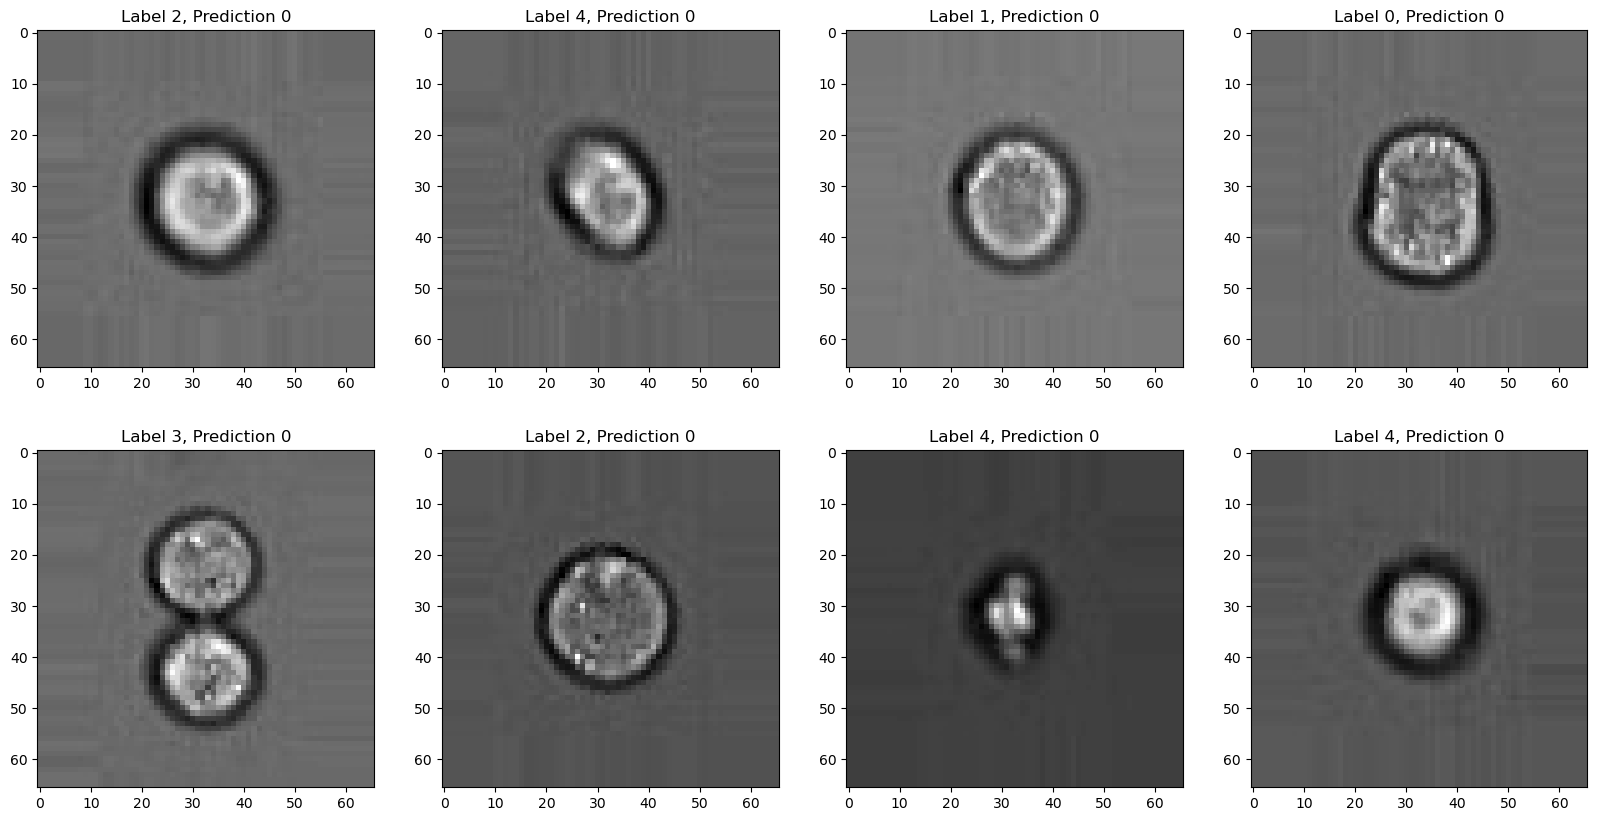

In [64]:
lc = LinearClassifier()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, j in enumerate(np.random.randint(X_test.shape[0], size=(8,))):
    # Get an example image
    X_sample = X_test[j, ...]

    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (66, 66))

    # Predict the label
    y_pred = lc.predict(X_sample)

    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap="gray")
    axes.flatten()[i].set_title(
        "Label " + str(np.argmax(y_test[j])) + ", Prediction " + str(np.argmax(y_pred))
    )

<div class="alert alert-block alert-info">

#### Task 2.1
What do you notice about the initial results of the model?

</div>

The model exclusively predicts a class of 0. This result makes sense given that we initialized the model with weights of 0.

## Stochastic gradient descent
To train this model, we will use stochastic gradient descent. In its simplest version, this algorithm consists of the following steps:
- Select several images from the training dataset at random
- Compute the gradient of the loss function with respect to the weights, given the selected images
- Update the weights using the update rule $W_{ij} \rightarrow W_{ij} - lr\frac{\partial loss}{\partial W_{ij}}$

Recall that the origin of this update rule is from multivariable calculus - the gradient tells us the direction in which the loss function increases the most. So to minimize the loss function we move in the opposite direction of the gradient.

Also recall from the course notes that for this problem we can compute the gradient analytically. The gradient is given by

\begin{equation}
\frac{\partial loss}{\partial W_{ij}} = \left(p_i - 1(i \mbox{ is correct}) \right)x_j,
\end{equation}
where $1$ is an indicator function that is 1 if the statement inside the parentheses is true and 0 if it is false.

A complete derivation of $\frac{\partial loss}{\partial W_{ij}}$ is included in the Towards Data Science [article](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) recommended above if you are interested in the details.

In [65]:
def grad(self, X, y_true, y_pred):
    # Compute the gradients for each class and save in list
    gradients = []
    for i in range(self.n_classes):
        # Calculate the difference between the class probability and true score
        difference = y_pred[..., i] - y_true[..., i]
        difference = np.expand_dims(difference, axis=-1)
        grad = difference * X
        gradients.append(grad)

    gradient = np.stack(gradients, axis=1)

    return gradient


def loss(self, X, y_true, y_pred):
    loss = np.mean(-y_true * np.log(y_pred))

    return loss


def fit(self, X_train, y_train, n_epochs, batch_size=1, learning_rate=1e-5):
    loss_list = []

    rng = np.random.default_rng()

    # Iterate over epochs
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")
        n_batches = int(np.floor(X_train.shape[0] / batch_size))

        # Generate random index
        index = np.arange(X_train.shape[0])
        np.random.shuffle(index)
        X_shfl = X_train[index]
        y_shfl = y_train[index]

        # Iterate over batches
        for batch in tqdm.trange(n_batches):
            beg = batch * batch_size
            end = (
                (batch + 1) * batch_size
                if (batch + 1) * batch_size < X_train.shape[0]
                else -1
            )
            X_batch = X_shfl[beg:end]
            y_batch = y_shfl[beg:end]

            # Skip empty batch if it shows up at the end of the epoch
            if X_batch.shape[0] == 0:
                continue

            # Predict
            y_pred = self.predict(X_batch)

            # Compute the loss
            loss = self.loss(X_batch, y_batch, y_pred)
            loss_list.append(loss)

            # Compute the gradient
            gradient = self.grad(X_batch, y_batch, y_pred)

            # Compute the mean gradient over all the example images
            gradient = np.mean(gradient, axis=0, keepdims=False)

            # Update the weights
            self.W -= learning_rate * gradient

            if np.count_nonzero(np.isnan(self.W)) != 0:
                print(epoch, batch)
                break
                
        print('Final loss', loss)

    return loss_list


# Assign methods to class
setattr(LinearClassifier, "grad", grad)
setattr(LinearClassifier, "loss", loss)
setattr(LinearClassifier, "fit", fit)

We're ready to train our model!

In [66]:
%%time
lc = LinearClassifier()
loss_log = lc.fit(X_train, y_train, n_epochs=10, batch_size=16)

Epoch 0


 11%|██████████████▎                                                                                                                     | 1995/18367 [00:02<00:18, 879.12it/s]/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_3727/3971853369.py:17: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-y_true * np.log(y_pred))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_3727/3971853369.py:17: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean(-y_true * np.log(y_pred))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 879.44it/s]


Final loss 1.7214604084965548
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:21<00:00, 852.91it/s]


Final loss 1.9109381792245197
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 894.82it/s]


Final loss 1.139467125055438
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 905.89it/s]


Final loss 2.705778176879354
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 884.68it/s]


Final loss 2.038536004662414
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:19<00:00, 920.45it/s]


Final loss 1.13966066943694
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 891.46it/s]


Final loss 3.628015444805151
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 901.30it/s]


Final loss 0.6483540248530424
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:20<00:00, 899.39it/s]


Final loss 0.8567119473949215
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18367/18367 [00:19<00:00, 919.25it/s]

Final loss 0.5873592471512668
CPU times: user 25min 33s, sys: 1min 57s, total: 27min 31s
Wall time: 3min 27s


Let's plot the loss curve to see how the model trained.

In [67]:
def smooth(scalars, weight):
    """Compute the exponential moving average to smooth data

    Credit: https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar/49357445#49357445

    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)  # Save it
        last = smoothed_val  # Anchor the last smoothed value

    return smoothed

Text(0, 0.5, 'loss')

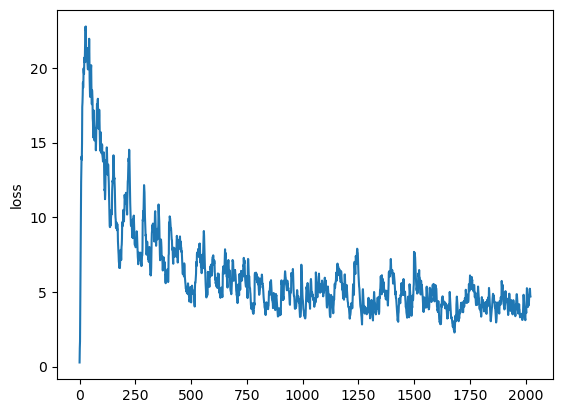

In [68]:
fig, ax = plt.subplots()
ax.plot(smooth(loss_log, 0.9))
ax.set_ylabel("loss")

## Evaluate the model

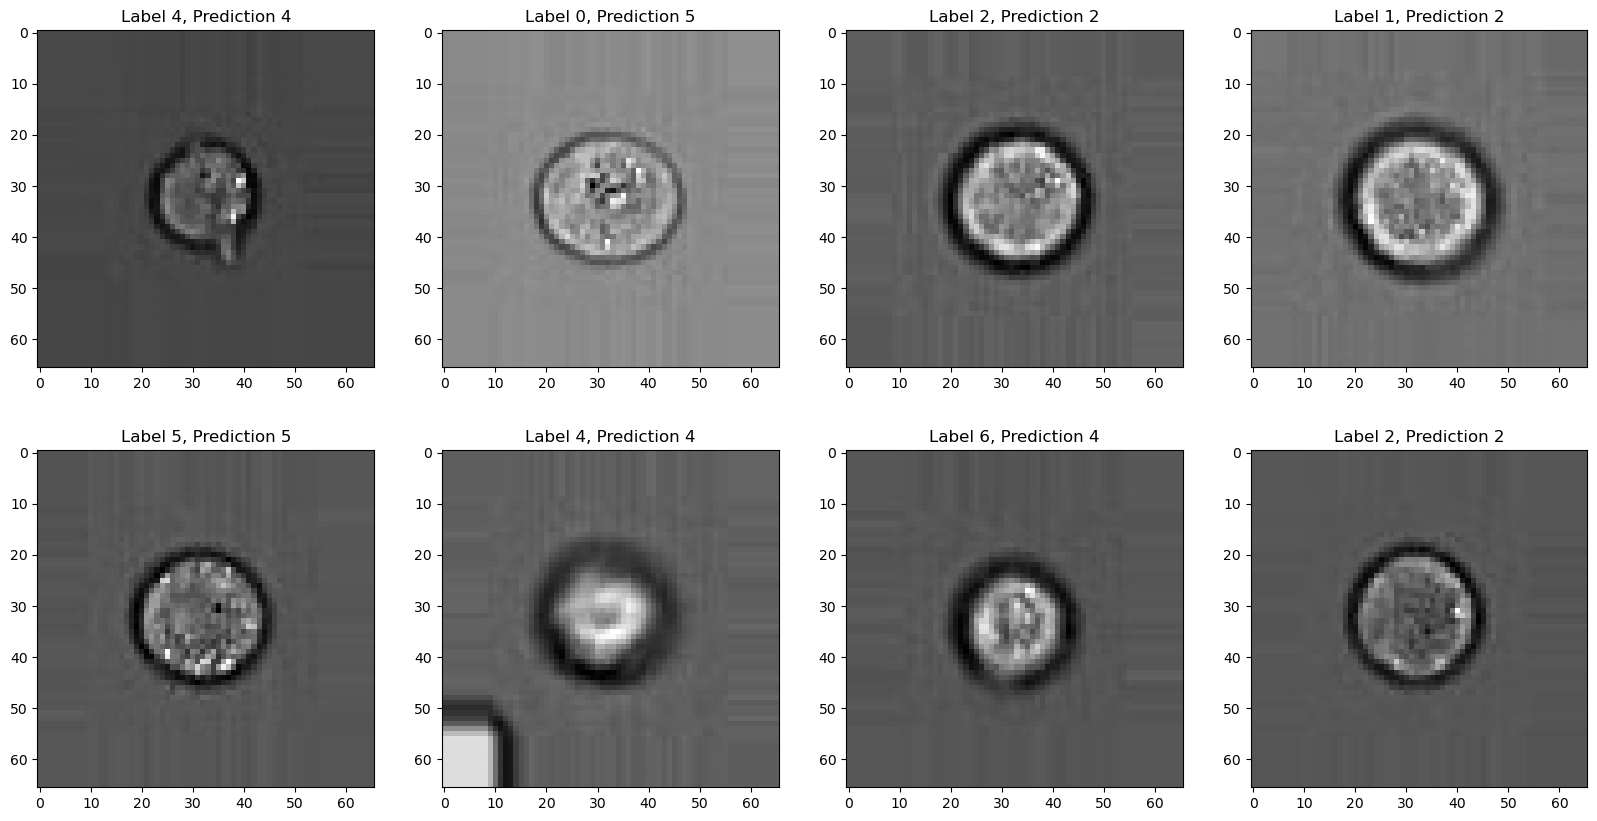

In [69]:
# Visualize some predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, j in enumerate(np.random.randint(X_test.shape[0], size=(8,))):
    # Get an example image
    X_sample = X_test[j]

    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (66, 66))

    # Predict the label
    y_pred = lc.predict(X_sample)

    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap="gray")
    axes.flatten()[i].set_title(
        "Label " + str(np.argmax(y_test[j])) + ", Prediction " + str(np.argmax(y_pred))
    )

In addition to inspecting the results of individual predictions, we can also look at summary statistics that capture model performance.

In [73]:
def benchmark_performance(y_true, y_pred):
    """Calculates recall, precision, f1 and a confusion matrix for sample predictions

    Args:
        y_true (list): List of integers of true class values
        y_pred (list): List of integers of predicted class value

    Returns:
        dict: Dictionary with keys `recall`, `precision`, `f1`, and `cm`

    """
    _round = lambda x: round(x, 3)

    metrics = {
        "recall": _round(sklearn.metrics.recall_score(y_true, y_pred, average="macro")),
        "precision": _round(
            sklearn.metrics.precision_score(y_true, y_pred, average="macro")
        ),
        "f1": _round(sklearn.metrics.f1_score(y_true, y_pred, average="macro")),
        "cm": sklearn.metrics.confusion_matrix(y_true, y_pred, normalize=None),
        "cm_norm": sklearn.metrics.confusion_matrix(y_true, y_pred, normalize="true"),
    }

    return metrics

<div class="alert alert-block alert-info">

#### Task 2.2

For each of the 4 metrics above, describe in your own words what this metric tells you about model performance.

- Recall
- Precision
- F1
- Confusion Matrix

</div>

*Write your answers here*
- Recall
- Precision
- F1 Score
- Confusion Matrix

- Recall -- Measures the ratio of true positives to the total positives that the model should have identified. Captures the ability of the model to find all positive samples. $$\frac{\texttt{true positive}}{\texttt{true positive} + \texttt{false negative}}$$
- Precision -- Measures the ratio of true positives to all positive predictions. Captures the ability of the model to accurately identify positive samples without misclassifying negative samples.
$$\frac{\texttt{true positive}}{\texttt{true positive} + \texttt{false positive}}$$
- F1 -- Summary statistic that captures both precision and recall
$$\frac{2*\texttt{precision}*\texttt{recall}}{\texttt{precision}+\texttt{recall}}$$
- Confusion Matrix -- Captures the exact failure modes of the model by contrasting predicted classes with true classes.

In [56]:
def plot_metrics(metrics, name, ax=None):
    """Plots a confusion matrix with summary statistics listed above the plot

    The annotations on the confusion matrix are the total counts while
    the colormap represents those counts normalized to the total true items
    in that class.

    Args:
        metrics (dict): Dictionary output of `benchmark_performance`
        name (str): Title for the plot
        ax (optional, matplotlib subplot): Subplot axis to plot onto.
            If not provided, a new plot is created
        classes (optional, list): A list of the classes to label the X and y
            axes. Defaults to [0, 1] for a two class problem.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    cb = ax.imshow(metrics["cm_norm"], cmap="Greens", vmin=0, vmax=1)

    classes = np.arange(metrics["cm"].shape[0])
    ax.set_xticks(range(len(classes)), class_lut)
    ax.set_yticks(range(len(classes)), class_lut)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    for i in range(len(classes)):
        for j in range(len(classes)):
            color = "green" if metrics["cm_norm"][i, j] < 0.5 else "white"
            ax.annotate(
                "{}".format(metrics["cm"][i, j]),
                (j, i),
                color=color,
                va="center",
                ha="center",
            )

    _ = plt.colorbar(cb, ax=ax)
    _ = ax.set_title(
        "{}\n"
        "Recall: {}\n"
        "Precision: {}\n"
        "F1 Score: {}\n"
        "".format(name, metrics["recall"], metrics["precision"], metrics["f1"])
    )

In [74]:
def summarize_performance(model, X_train, y_train, X_test, y_test, title=''):
    """Quick function to generate predictions on the train and test splits, 
    benchmark and plot the results
    """
    
    # Generate predictions and metrics for training data
    y_pred = model.predict(X_train)
    # Convert from one hot encoding to original class labels
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_train, axis=-1)
    train_metrics = benchmark_performance(y_true, y_pred)

    # Generate predictions and metrics for test data
    y_pred = model.predict(X_test)
    # Convert from one hot encoding to original class labels
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    test_metrics = benchmark_performance(y_true, y_pred)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    plot_metrics(train_metrics, f"{title} Training", ax[0])
    plot_metrics(test_metrics, f"{title} Testing", ax[1])

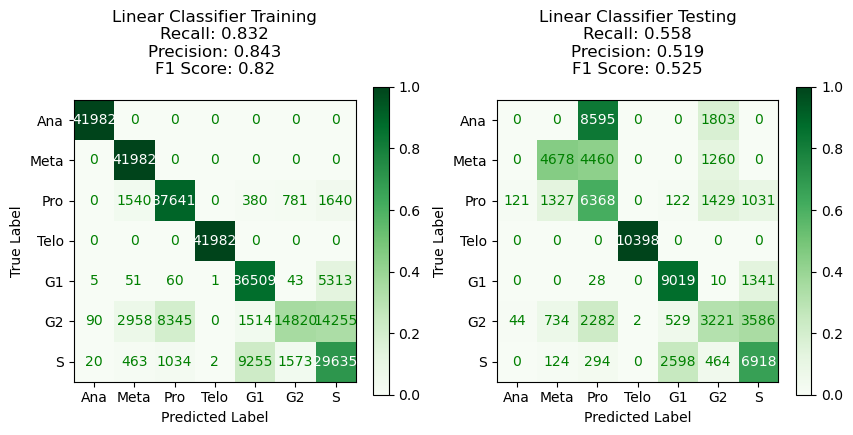

In [75]:
summarize_performance(lc, X_train, y_train, X_test, y_test, "Linear Classifier")

<div class="alert alert-block alert-info">

#### Task 2.3

What do you notice about the results after training the model?

</div>

<div class="alert alert-block alert-success">

## Checkpoint 2

We have written a simple linear classifier, trained it and considered a few ways to evaluate model performance. Next we'll look at some other machine learning methods for classification.

</div>

# Part B: Random Forest Classifier

Decisions trees are a useful tool for generating interpretable classification results. As shown in the example below, trees are constructed such that the data is split at each node according to a feature in the data. At the bottom of the tree, the leafs should correspond to a single class such that we can predict the class of the data depending on which leaf it is associated with.

![](https://miro.medium.com/v2/resize:fit:1262/format:webp/1*LMoJmXCsQlciGTEyoSN39g.jpeg)

(*Image by [Tony Yiu](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)*)

A random forest classifer is much like what it sounds. It takes predictions from many different decision trees and assigns the class with the most votes. Ultimately this ensemble method of considering many different trees performs better than any one decision tree.

![](https://miro.medium.com/v2/resize:fit:1052/format:webp/1*VHDtVaDPNepRglIAv72BFg.jpeg)

(*Image by [Tony Yiu](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)*)

In this exercise, we will use `scikit-learn's` implementation of `RandomForestClassifier` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [80]:
%%time
rfc = sklearn.ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

KeyboardInterrupt: 

/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:882: RuntimeWarning: invalid value encountered in divide
  proba /= len(self.estimators_)
/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:882: RuntimeWarning: invalid value encountered in divide
  proba /= len(self.estimators_)
/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

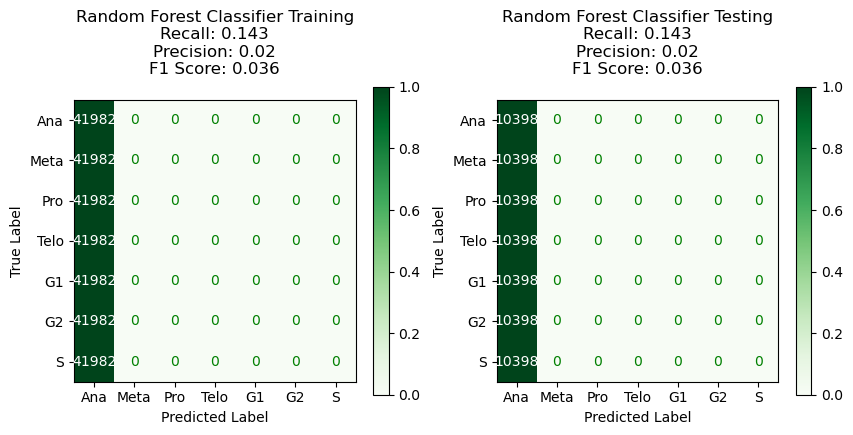

In [81]:
summarize_performance(rfc, X_train, y_train, X_test, y_test, "Random Forest Classifier")

## Parameter Optimization

Our initial random forest classifier was trained using the default parameters provided by `sklearn`, but these often won't be the right values for our problem. In many situations, we may have some idea what a reasonable parameter value might be, but most of the time we will need to perform a grid search to select the optimal value. `sklearn` provides a class `RandomizedSearchCV` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)) to perform a random search over a provided grid of parameters, which we can use to improve the performance of the random forest classifier.

<div class="alert alert-block alert-info">

#### Task 3.1

For this task, your job is to select a set of parameters to use for optimization. You should start by looking at the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for `RandomForestClassifier` to see what parameters are available. For each parameter that you choose to optimize, think about what range of values you should try.

For example:
```
parameter_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2, 3]
}
```

Fill out the dictionary below with your parameter selection.

</div>

In [35]:
##########################
######## To Do ###########
##########################

# Here's a few possible parameter types to consider, but there are more possibilities

parameter_grid = {
    "n_estimators": ...,
    "criterion": ...,
    "max_depth": ...,
    "min_samples_leaf": ...
}

In [36]:
##########################
####### Solution #########
##########################

parameter_grid = {
    "n_estimators": np.linspace(100, 2000, 10, dtype=int),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [1, 5, 10, 20, 50, 75, 100, 150, 200],
    "min_samples_split": [2, 5, 10, 15, 20, 30],
    "min_samples_leaf": [1, 2, 3, 4],
    "bootstrap": [True, False],
}

If we had more time, we could use `RandomizedSearchCV` to look for the best set of parameters:

```python
rf_random = sklearn.model_selection.RandomizedSearchCV(
    estimator=sklearn.ensemble.RandomForestClassifier(),
    param_distributions=parameter_grid,
    n_iter=5,
    verbose=3)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
```

However to save on time we are going to distribute the work among the group.

<div class="alert alert-block alert-success">

## Checkpoint 3

We'll come back together as a group to discuss the parameter space that we want to explore and to sign up for parameter configurations.

</div>

<div class="alert alert-block alert-info">

#### Task 4.1

Configure the `RandomForestClassifier` below with a set of parameters according to the parameter space we discussed during the previous checkpoint. Then train and evaluate your classifier!

</div>

In [37]:
##########################
######## To Do ###########
##########################

random_rfc = sklearn.ensemble.RandomForestClassifier(
    # Add your parameter configuration here
)

/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 2min 52s, sys: 701 ms, total: 2min 53s
Wall time: 2min 53s


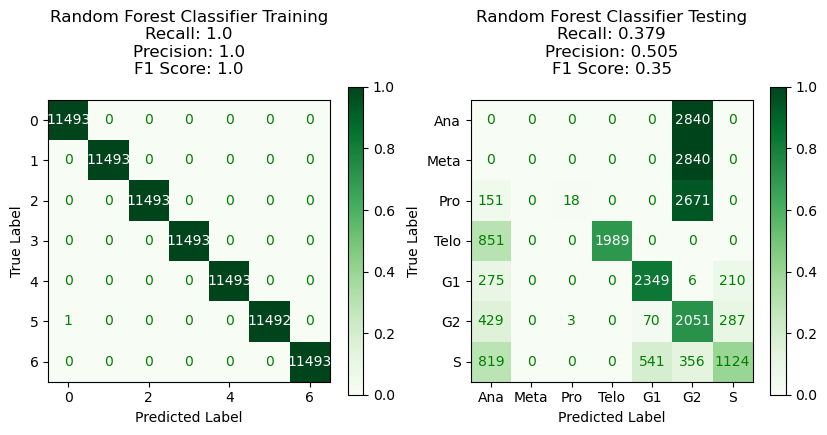

In [38]:
%%time
random_rfc.fit(X_train, y_train)

summarize_performance(rfc, X_train, y_train, X_test, y_test, "Random Forest Classifier")

<div class="alert alert-block alert-success">

## Checkpoint 4

Report the performance of your model on the test split in the group spreadsheet (check Element for a link). We'll discuss what seems to be working best as a group.

</div>

# Part C: Feature Engineering

Classical machine learning methods often turn to manual feature engineering to extract elements of the data that the model will use for prediction. So far we have relied on the raw data alone, but in some cases well designed features can produce a better model than raw data alone.

## Introduction to image filters

TODO a good example would be a filter that does something, e.g. blurring, then ask for the identity as a sanity check if people got it.

Image filters operate by taking a small kernel (or matrix) and applying it to each pixel in the image to compute a new value. As an example, this is the identity kernel
$$
\begin{bmatrix}
    0 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
$$
which when applied to an image will not result in any changes to the data.

Filters can produce a variety of effects on images depending on how the kernel is configured. This can range from blurring an image to extracting edges. Filtered images can contain data that is more informative to the model when distinguishing between classes.

Text(0.5, 1.0, 'Laplace')

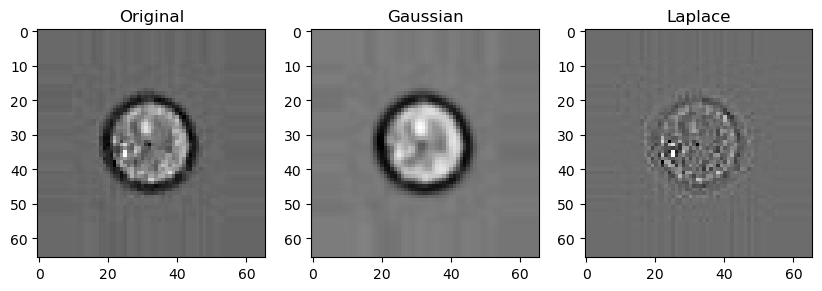

In [39]:
im = X_data[np.random.randint(X_data.shape[0]), ..., 0]
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].imshow(im, cmap="Greys_r")
ax[0].set_title("Original")

ax[1].imshow(skimage.filters.gaussian(im), cmap="Greys_r")
ax[1].set_title("Gaussian")

ax[2].imshow(skimage.filters.laplace(im), cmap="Greys_r")
ax[2].set_title("Laplace")

A variety of filters are made available through the `skimage.filters` [module](https://scikit-image.org/docs/stable/api/skimage.filters.html). In this part of the exercise, we are going to explore how filters can be applied to images in order to extract features for model prediction. While we are going to work with the filters that are easily available through skimage, there are many other transformations that can be applied to images.

In [40]:
from inspect import getmembers, isfunction

# List all functions in the skimage.filters module to get a list of available filters
[m[0] for m in getmembers(skimage.filters, isfunction)]

['apply_hysteresis_threshold',
 'butterworth',
 'compute_hessian_eigenvalues',
 'correlate_sparse',
 'difference_of_gaussians',
 'farid',
 'farid_h',
 'farid_v',
 'filter_inverse',
 'frangi',
 'gabor',
 'gabor_kernel',
 'gaussian',
 'hessian',
 'inverse',
 'laplace',
 'median',
 'meijering',
 'prewitt',
 'prewitt_h',
 'prewitt_v',
 'rank_order',
 'roberts',
 'roberts_neg_diag',
 'roberts_pos_diag',
 'sato',
 'scharr',
 'scharr_h',
 'scharr_v',
 'sobel',
 'sobel_h',
 'sobel_v',
 'threshold_isodata',
 'threshold_li',
 'threshold_local',
 'threshold_mean',
 'threshold_minimum',
 'threshold_multiotsu',
 'threshold_niblack',
 'threshold_otsu',
 'threshold_sauvola',
 'threshold_triangle',
 'threshold_yen',
 'try_all_threshold',
 'unsharp_mask',
 'wiener',
 'window']

<div class="alert alert-block alert-info">

#### Task 5.1

Test a variety of the available filters from the `skimage` module. Whenever you are making a modification to an image, you should check the results to make sure that errors are not introduced while generating the transformation. The easiest way to plot an image is just to run `plt.imshow(image)`.

Ultimately we are going to use model performance to select the best features for our classification task, but you should be familiar with the output of any filters that you are using. The goal of this next section is to identify a set of candidate filters from which one will be chosen that you think will lead to better classification results on the two classes we are trying to distinguish.

Keep the following things you may want to keep in mind as you approach this problem
- Look at several randomly selected images from the different classes when you are testing a filter
- Explore the effect of parameters available for each filter

**Challenge**: While this task could be approached by testing filters one at a time, consider writing a for loop to rapidly test filters in an automated fashion.


**Tip**: Within a jupyter notebook, you can run `function?` to look at the documentation for that function. Check out the example below.

</div>

In [41]:
skimage.filters.gaussian?

Signature:
skimage.filters.gaussian(
    image,
    sigma=1,
    output=None,
    mode='nearest',
    cval=0,
    preserve_range=False,
    truncate=4.0,
    *,
    channel_axis=<ChannelAxisNotSet>,
)
Docstring:
Multi-dimensional Gaussian filter.

Parameters
----------
image : array-like
    Input image (grayscale or color) to filter.
sigma : scalar or sequence of scalars, optional
    Standard deviation for Gaussian kernel. The standard
    deviations of the Gaussian filter are given for each axis as a
    sequence, or as a single number, in which case it is equal for
    all axes.
output : array, optional
    The ``output`` parameter passes an array in which to store the
    filter output.
mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
    The ``mode`` parameter determines how the array borders are
    handled, where ``cval`` is the value when mode is equal to
    'constant'. Default is 'nearest'.
cval : scalar, optional
    Value to fill past edges of input if

TypeError: Image data of dtype object cannot be converted to float

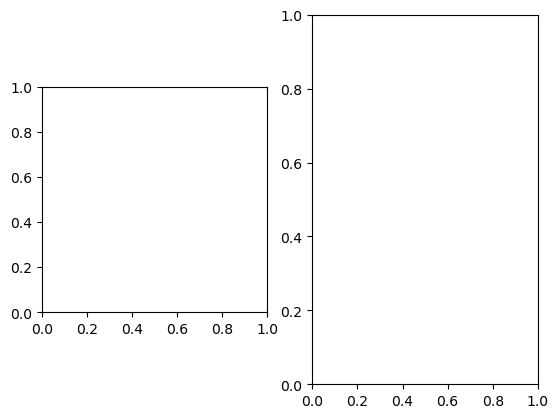

In [82]:
##########################
######## To Do ###########
##########################

# Put your code for testing filters here

# Hint
# Pick a test image
im = ...

# Apply a filter 
filtered = ...

# Plot the before and after
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im, cmap='Greys_r')
ax[1].imshow(filtered, cmap='Greys_r')

In [43]:
filters = {
    "butterworth": skimage.filters.butterworth,
    # We can use a lambda function to configure this function with default parameters of 2 and 10
    "difference_of_gaussians": lambda im: skimage.filters.difference_of_gaussians(
        im, low_sigma=2, high_sigma=10
    ),
    "farid": skimage.filters.farid,
    "farid_h": skimage.filters.farid_h,
    "farid_v": skimage.filters.farid_v,
    "frangi": skimage.filters.frangi,
    "gaussian": skimage.filters.gaussian,
    "hessian": skimage.filters.hessian,
    "laplace": skimage.filters.laplace,
    "median": skimage.filters.median,
    "meijering": skimage.filters.meijering,
    "prewitt": skimage.filters.prewitt,
    "prewitt_h": skimage.filters.prewitt_h,
    "prewitt_v": skimage.filters.prewitt_v,
    "roberts": skimage.filters.roberts,
    "roberts_neg_diag": skimage.filters.roberts_neg_diag,
    "roberts_pos_diag": skimage.filters.roberts_pos_diag,
    "sato": skimage.filters.sato,
    "scharr": skimage.filters.scharr,
    "scharr_h": skimage.filters.scharr_h,
    "scharr_v": skimage.filters.scharr_v,
    "sobel": skimage.filters.sobel,
    "sobel_h": skimage.filters.sobel_h,
    "sobel_v": skimage.filters.sobel_v,
    "unsharp_mask": skimage.filters.unsharp_mask,
}

First we will try applying each filter to a sample image. By setting up the for loop with a try/except block, we can catch any errors that appear and correct them in a second iteration.

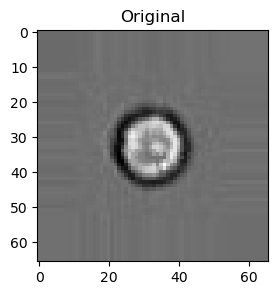

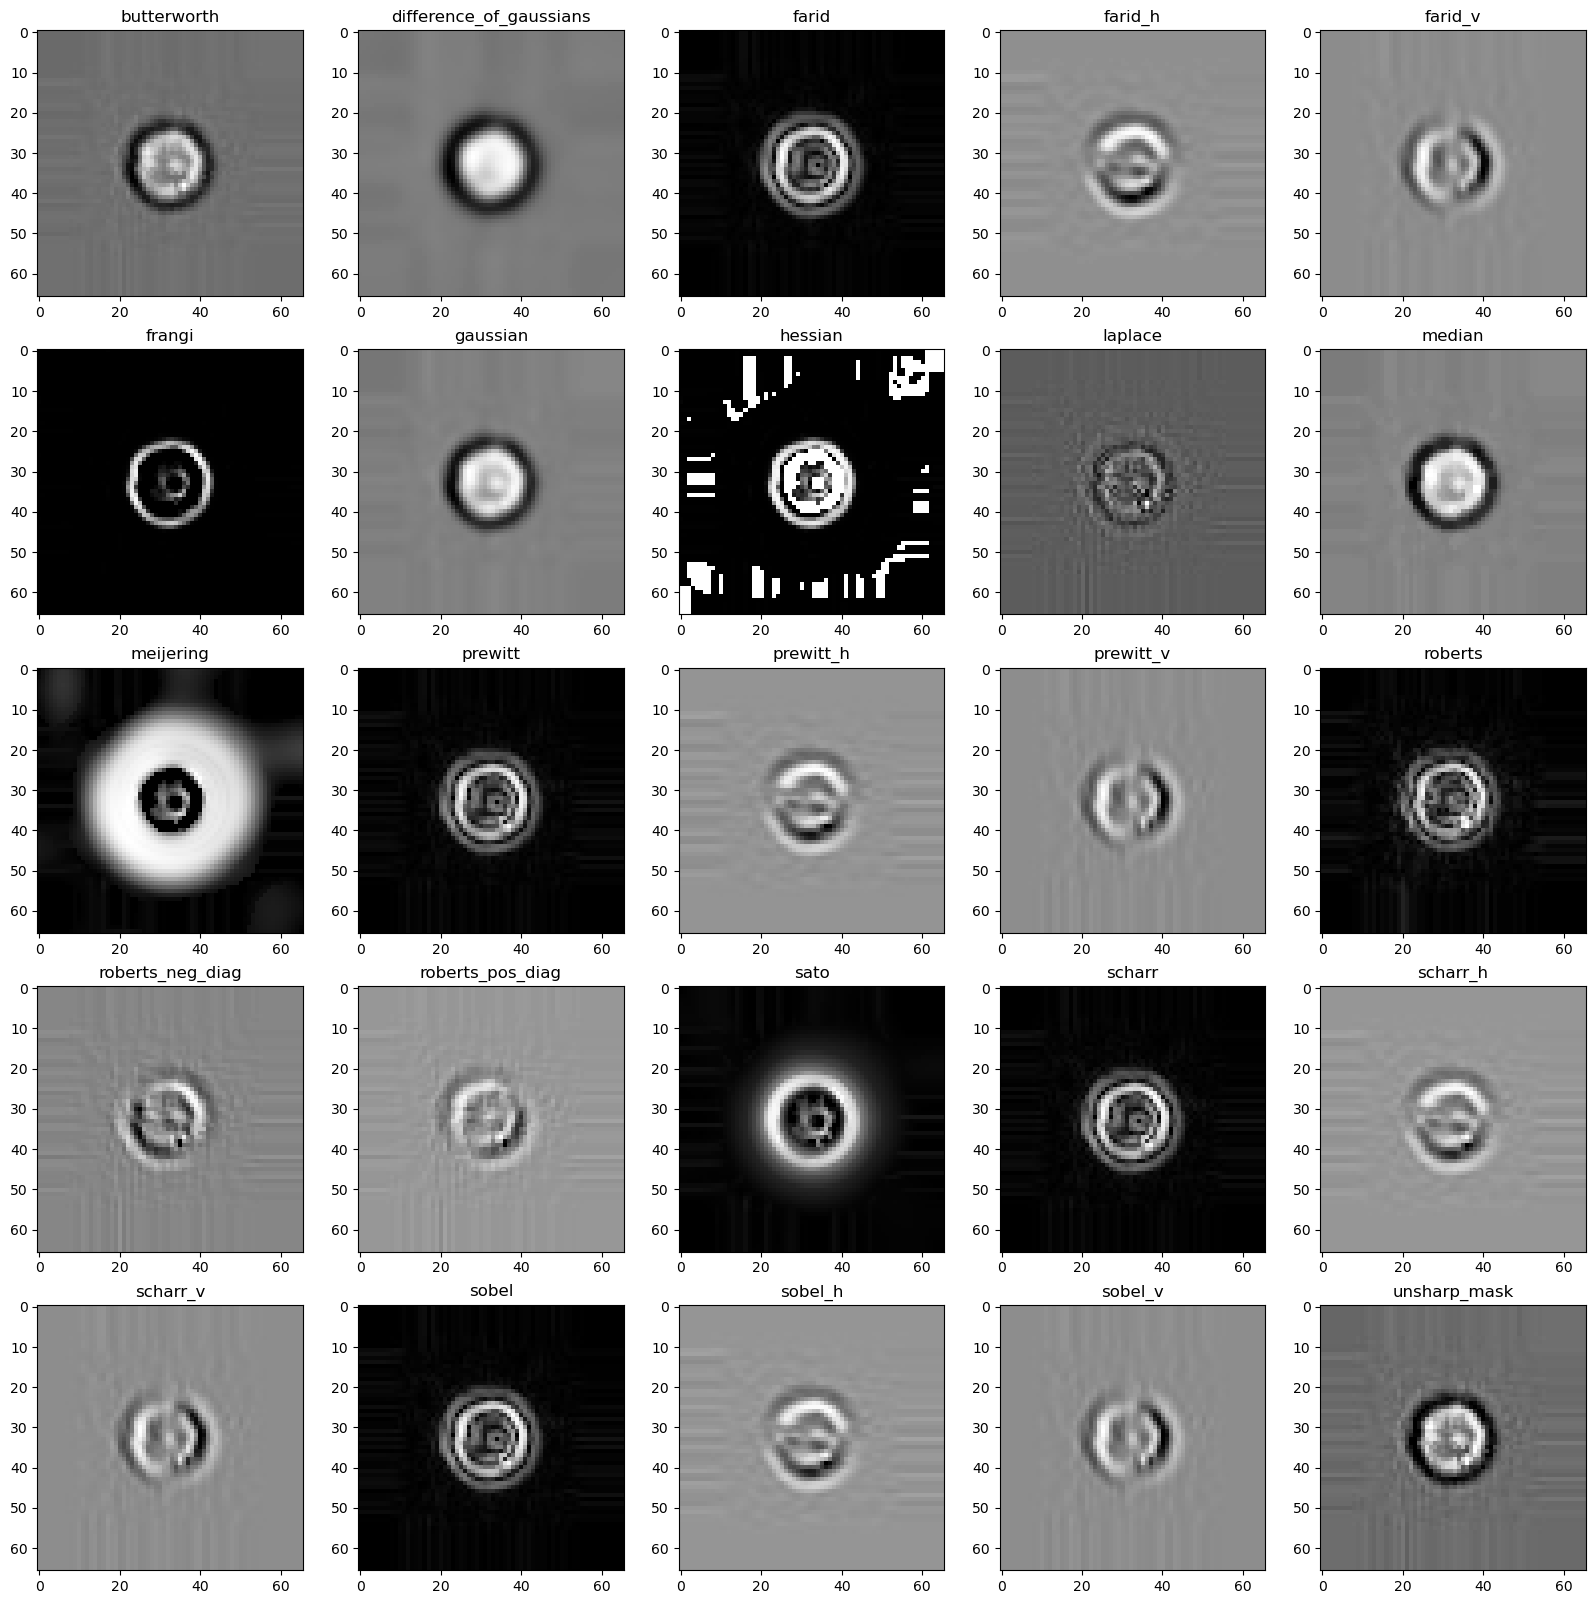

In [44]:
# Select random image
im = X_data[np.random.randint(X_data.shape[0]), ..., 0]

# Plot original image
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(im, cmap="Greys_r")
ax.set_title("Original")

# Plot filtered images
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i, (name, fxn) in enumerate(filters.items()):
    ax.flatten()[i].set_title(name)
    try:
        ax.flatten()[i].imshow(fxn(im), cmap="Greys_r")
    except Exception as e:
        print("Skipping {}: {}".format(name, e))

Now we'll look at how different parameters can change the effect of some of these filters.

In [45]:
n_params = 3

filter_params = [
    {"function": skimage.filters.gaussian, "sigma": [1, 2, 5]},
    {
        "function": skimage.filters.difference_of_gaussians,
        "low_sigma": [1, 2, 5],
        "high_sigma": [2, 5, 10],
    },
    {"function": skimage.filters.laplace, "ksize": [3, 10, 20]},
]

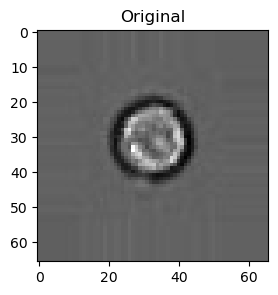

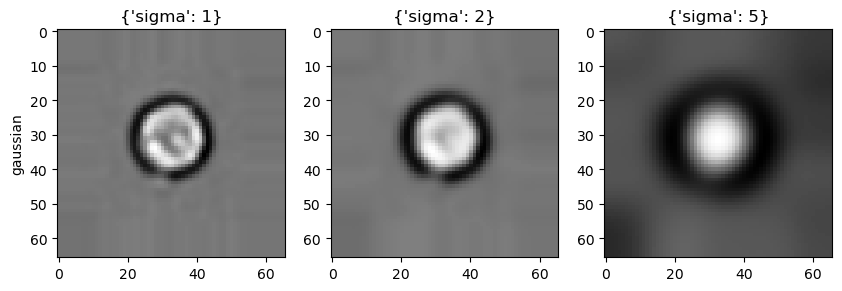

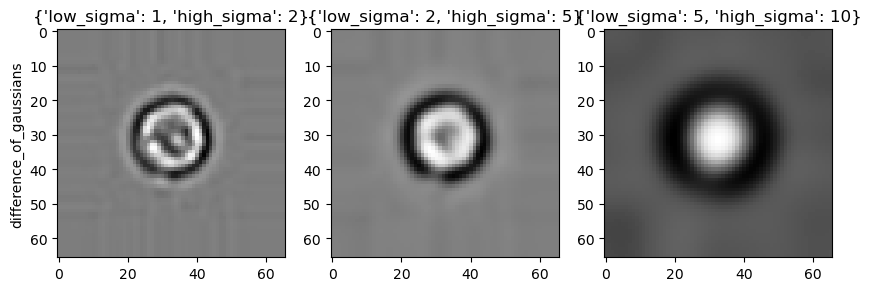

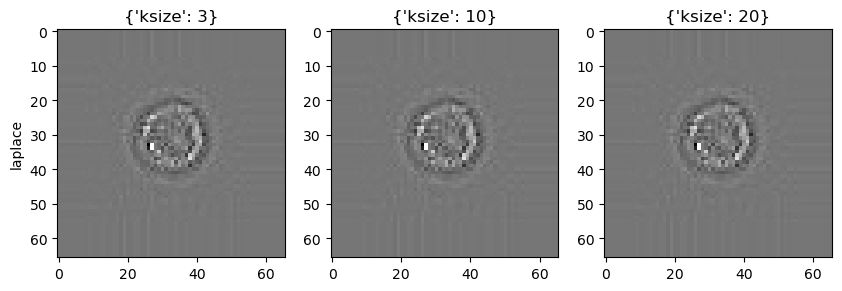

In [46]:
# Select random image
im = X_data[np.random.randint(X_data.shape[0]), ..., 0]

# Plot original image
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(im, cmap="Greys_r")
ax.set_title("Original")

# Plot filtered images
for config in filter_params:
    fig, ax = plt.subplots(1, n_params, figsize=(10, 3))
    ax[0].set_ylabel(config["function"].__name__)

    for i in range(n_params):
        # Construct kwargs for each case
        kwargs = {}
        for k, v in config.items():
            if k == "function":
                continue
            else:
                kwargs[k] = v[i]

        # Plot filtered image
        ax[i].imshow(config["function"](im, **kwargs), cmap="Greys_r")
        ax[i].set_title(str(kwargs))

Let's look at three candidate filters on several images from each class.

In [47]:
candidates = {
    "original": lambda im: im,
    "difference_of_gaussians": lambda im: skimage.filters.difference_of_gaussians(
        im, low_sigma=1, high_sigma=2
    ),
    "farid": skimage.filters.farid,
    "frangi": skimage.filters.frangi,
}

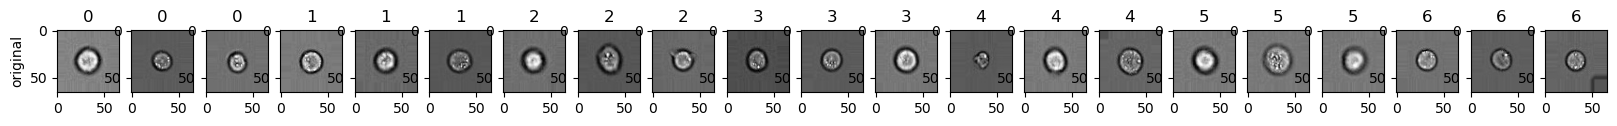

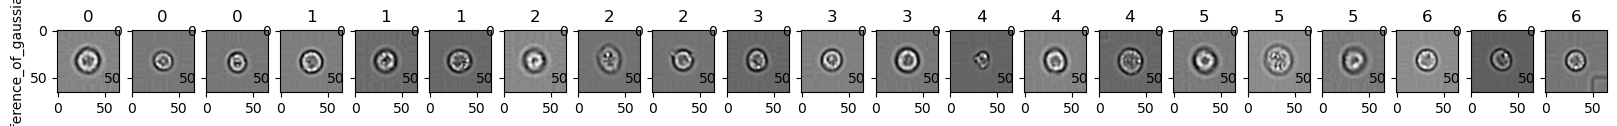

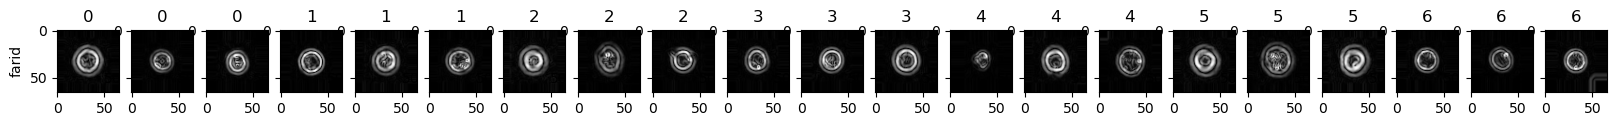

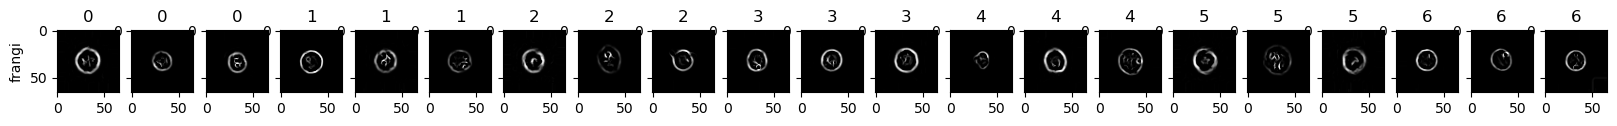

In [48]:
nsamples = 3

# Take a random sampling from each class
idxs, classes = [], []
for c in np.unique(y_data):
    xx = X_data[y_data == c]
    samples = np.random.randint(xx.shape[0], size=(nsamples,))
    idxs.extend(samples)
    classes.extend([c] * nsamples)

for name, fxn in candidates.items():
    fig, ax = plt.subplots(1, nsamples * 7, figsize=(20, 5))
    ax[0].set_ylabel(name)

    for i, (c, idx) in enumerate(zip(classes, idxs)):
        ax[i].imshow(fxn(X_data[idx, ..., 0]), cmap="Greys_r")
        ax[i].set_title(c)

<div class="alert alert-block alert-info">

#### Task 5.2

Your challenge now is to combine the features that you have explored with one of the two models we've trained so far. It's up to you to select a set of features and model design that you think will produce the best results. We'll compare results as a group at the end.

As you approach this task, you are encouraged to copy/paste code from earlier in the exercise and modify it as needed. Here's a rough outline of what you will need to do:
- Build a new dataset with your selected filters. The easiest way to combine data from multiple filters is to concatenate images together along the axis corresponding to the image size. For example if our initial training data has the shape `(n_images, image_width * image_width)`, the new data will have the shape `(n_images, n_filters * image_width * image_width)`. Here's a code snippet to get you started:
```python
# Select single image (10) and channel (0)
im = X_data[10, ..., 0]
gaus = skimage.filters.gaussian(im)
lapl = skimage.filters.laplace(im)

# Flatten each image
im = np.reshape(im, (image_width * image_width))
gaus = np.reshape(gaus, (image_width * image_width))
lapl = np.reshape(lapl, (image_width * image_width))

# Concatenate together
ims = np.concatenate([im, gaus, lapl], axis=-1)
```

- Finish assembling your dataset by splitting into train/test split (`sklearn.model_selection.train_test_split`), balancing classes (`imblearn.over_sampling.RandomOverSampler`) and one hot encoding (`sklearn.label_processing.LabelBinarizer`)

- Configure your model. If you choose the `LinearClassifier` make sure you update the `image_size` parameter to match the dimensions of your new dataset.

- Train and evaluate the results
</div>

In [49]:
# Generate filtered data
frangi = np.stack([skimage.filters.frangi(im) for im in X_data[..., 0]])
sobel = np.stack([skimage.filters.sobel(im) for im in X_data[..., 0]])

Xs = [
    np.reshape(x, (-1, image_width * image_width))
    for x in [X_data[..., 0], frangi, sobel]
]
X_filtered = np.concatenate(Xs, axis=-1)
X_filtered.shape

(32266, 13068)

In [50]:
# Split the dataset into training, validation, and testing splits
seed = 10
train_size = 0.8
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_filtered, y_data, train_size=train_size, random_state=seed
)

In [51]:
# Balance classes using the same function as above
X_train, y_train = balance_classes(X_train, y_train)
X_test, y_test = balance_classes(X_test, y_test)
print(f"Train shape: X {X_train.shape}, y {y_train.shape}")
print(f"Test shape: X {X_test.shape}, y {y_test.shape}")

Starting distribution: Counter({4: 11493, 6: 6888, 5: 6859, 2: 484, 1: 57, 3: 20, 0: 11})
Corrected distribution: Counter({4: 11493, 5: 11493, 1: 11493, 6: 11493, 2: 11493, 3: 11493, 0: 11493})
Starting distribution: Counter({4: 2840, 5: 1742, 6: 1728, 2: 122, 1: 11, 3: 7, 0: 4})
Corrected distribution: Counter({4: 2840, 5: 2840, 6: 2840, 0: 2840, 3: 2840, 2: 2840, 1: 2840})
Train shape: X (80451, 4356), y (80451,)
Test shape: X (19880, 4356), y (19880,)


In [52]:
# One hot encoding using the same LabelBinarizer object
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [53]:
%%time
# Initialize linear classifier with the new data shape
lcf = LinearClassifier(image_size=X_train.shape[1])
loss_log = lcf.fit(X_train, y_train, n_epochs=50, batch_size=16)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 647.76it/s]


Epoch 1


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 2705/5028 [00:04<00:05, 387.43it/s]/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_93993/976666212.py:17: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-y_true * np.log(y_pred))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_93993/976666212.py:17: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean(-y_true * np.log(y_pred))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 570.07it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 638.04it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 611.71it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 589.22it/s]


Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 603.02it/s]


Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 634.69it/s]


Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 681.41it/s]


Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 633.13it/s]


Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 610.93it/s]


Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 669.09it/s]


Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 524.81it/s]


Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 567.12it/s]


Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 545.50it/s]


Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 543.10it/s]


Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 652.44it/s]


Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 686.28it/s]


Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 690.66it/s]


Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 672.20it/s]


Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 704.62it/s]


Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 531.04it/s]


Epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 549.44it/s]


Epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 606.14it/s]


Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 606.60it/s]


Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 690.25it/s]


Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 614.70it/s]


Epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 614.97it/s]


Epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 629.02it/s]


Epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 698.41it/s]


Epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 683.86it/s]


Epoch 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 657.57it/s]


Epoch 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 671.46it/s]


Epoch 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 624.46it/s]


Epoch 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 648.44it/s]


Epoch 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 682.27it/s]


Epoch 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 649.91it/s]


Epoch 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 646.92it/s]


Epoch 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 585.88it/s]


Epoch 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 546.73it/s]


Epoch 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 580.20it/s]


Epoch 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 617.06it/s]


Epoch 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 678.43it/s]


Epoch 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 658.21it/s]


Epoch 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 616.98it/s]


Epoch 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:09<00:00, 551.25it/s]


Epoch 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 567.98it/s]


Epoch 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 570.46it/s]


Epoch 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:08<00:00, 578.77it/s]


Epoch 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 631.91it/s]


Epoch 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:07<00:00, 632.19it/s]

CPU times: user 47min 24s, sys: 6min 7s, total: 53min 31s
Wall time: 6min 50s


Text(0, 0.5, 'loss')

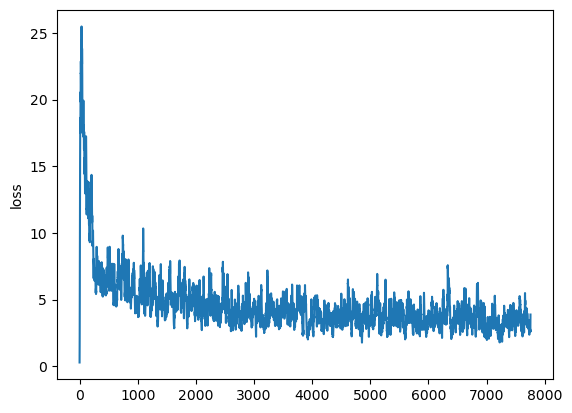

In [54]:
fig, ax = plt.subplots()
ax.plot(smooth(loss_log, 0.9))
ax.set_ylabel("loss")

/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


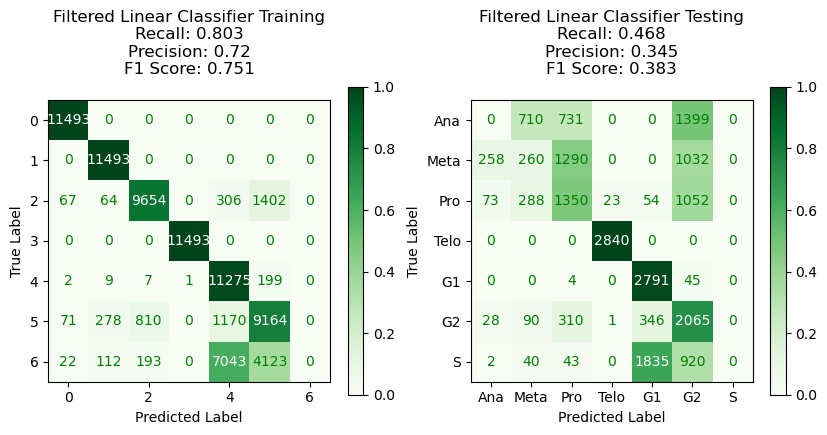

In [55]:
summarize_performance(rfc, X_train, y_train, X_test, y_test, "Filtered Linear Classifier")

<div class="alert alert-block alert-success">

## Checkpoint 5

Share the results of your model on the spreadsheet (see Element for the link) and we'll compare results as a group.
</div>